In [1]:
# Mount Google Drive (if your dataset is stored in Google Drive)
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

MessageError: Error: credential propagation was unsuccessful

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful



**Data Preprocessing**

In [ ]:
import os
import cv2
import numpy as np

dataset_path ="/content/drive/MyDrive/extracted_dataset"

images = []
labels = []

class_to_disease = {
    "Bacterial leaf blight": "Bacterial Leaf Blight",
    "Brown spot": "Brown Spot",
    "Leaf smut": "Leaf Smut",
    "Narrow Brown Spot" : "Narrow Brown Spot",
    "Rice Blast" : "Rice Blast",
    "Healthy": "Healthy"
}

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(class_to_disease[class_folder])

images = np.array(images)
labels = np.array(labels)

disease_names = np.unique(labels)

for i, disease_name in enumerate(disease_names):
    print("Disease Name:", disease_name, " - Label:", i)


Disease Name: Bacterial Leaf Blight  - Label: 0
Disease Name: Brown Spot  - Label: 1
Disease Name: Healthy  - Label: 2
Disease Name: Leaf Smut  - Label: 3
Disease Name: Narrow Brown Spot  - Label: 4
Disease Name: Rice Blast  - Label: 5


In [ ]:
class_names = np.unique(labels)
print("Class names:", class_names)

Class names: ['Bacterial Leaf Blight' 'Brown Spot' 'Healthy' 'Leaf Smut'
 'Narrow Brown Spot' 'Rice Blast']


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Normalize pixel values to [0, 1]
images = images.astype('float32') / 255.0

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)



**Train - Test - Split**

In [ ]:
# Split the dataset into training and testing sets
images, labels = shuffle(images, labels, random_state = 42)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)

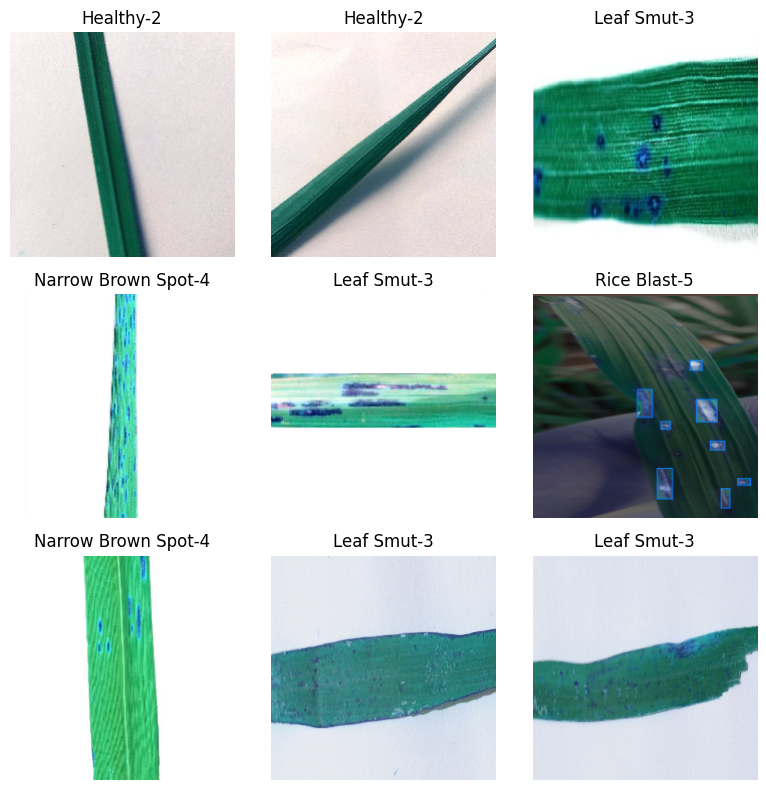

In [ ]:
import matplotlib.pyplot as plt

label_to_class = {label_idx: class_name for label_idx, class_name in enumerate(label_encoder.classes_)}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axes = axes.ravel()

for i in range(9):
    rand_index = np.random.randint(0, len(images))
    axes[i].imshow(images[rand_index])
    label_idx = labels[rand_index]
    class_name = label_to_class[label_idx]
    axes[i].set_title(f"{class_name}-{label_idx}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()



**Feature Extraction**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features from the images using the VGG16 model
train_features = base_model.predict(train_images)
test_features = base_model.predict(test_images)



2/2 [==============================] - 4s 4s/step


**Data Augmentation**

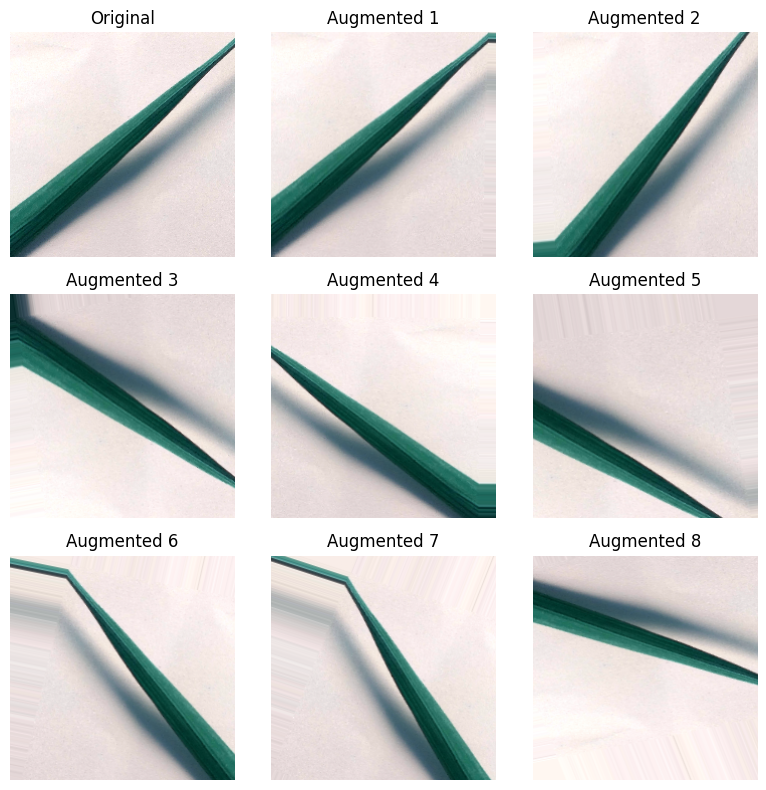

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''# Set your dataset path
dataset_path = "/content/drive/MyDrive/extracted_dataset"

# Load and preprocess images
images = []
labels = []

class_to_disease = {
    "Bacterial leaf blight": "Bacterial Leaf Blight",
    "Brown spot": "Brown Spot",
    "Leaf smut": "Leaf Smut",
    "Narrow Brown Spot" : "Narrow Brown Spot",
    "Healthy": "Healthy"
}

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(class_to_disease[class_folder])

images = np.array(images)
labels = np.array(labels)

# Normalize pixel values to [0, 1]
images = images.astype('float32') / 255.0

# Shuffle and split the dataset
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

images, labels = shuffle(images, labels, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
'''
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

# Visualize augmented images for the first training sample
img = train_images[0].reshape((1,) + train_images[0].shape)

augmented_images = []
for _ in range(9):
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_images.append(augmented_img)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axes = axes.ravel()

axes[0].imshow(img[0])
axes[0].set_title("Original")
axes[0].axis('off')

for i in range(1, 9):
    axes[i].imshow(augmented_images[i-1])
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Model Training using SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Flatten the feature vectors
train_features_flat = train_features.reshape(train_features.shape[0], -1)

# Initialize an SVM classifier
svm = SVC()

param_grid = {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]}


grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(train_features_flat, train_labels)

# Get the best SVM model
svm_model = grid_search.best_estimator_
# Train the SVM model
svm_model.fit(train_features_flat, train_labels)



SVC(C=10, gamma=0.001)

**Model Evaluation using SVM**

Accuracy: 0.875
[[6 0 0 0 0 0]
 [1 7 0 2 0 0]
 [0 0 9 0 0 0]
 [0 3 0 6 0 0]
 [0 0 0 0 7 0]
 [0 0 0 0 0 7]]


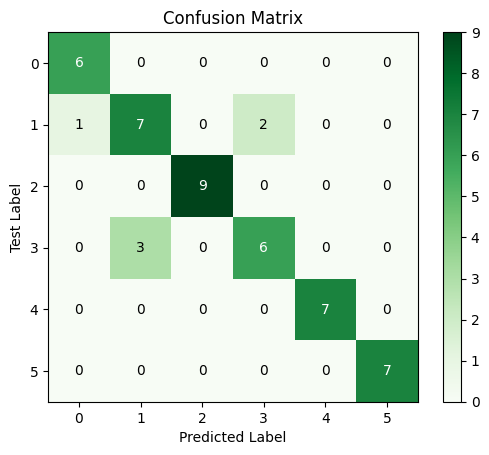

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Reshape the test features
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Predict labels for the test set
predicted_labels = svm_model.predict(test_features_flat)

# Calculate accuracy and other evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels)
report = classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_)

print("Accuracy:", accuracy)
print(confusion_matrix(test_labels,predicted_labels))

cm = confusion_matrix(test_labels, predicted_labels)
classes = np.unique(test_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# Label the matrix with the counts
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

# Add axis labels
plt.xlabel('Predicted Label')
plt.ylabel('Test Label')

# Show the plot
plt.show()


In [ ]:
train_predicted_labels = svm_model.predict(train_features_flat)

train_accuracy_svm = accuracy_score(train_labels, train_predicted_labels)

print("Training Accuracy (SVM):", train_accuracy_svm)


Training Accuracy (SVM): 1.0


**SVM Model Prediction**

1/1 [==============================] - 1s 1s/step
Predicted disease: Narrow Brown Spot


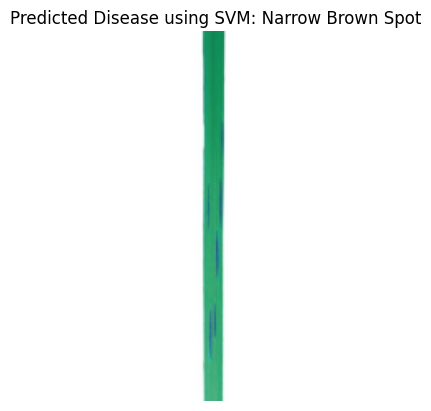

Remedies : 
Use balanced nutrients; make sure that adequate potassium is used and spray propiconazole at booting to heading stages.


In [ ]:
from skimage.transform import resize

image_path = '/content/drive/MyDrive/extracted_dataset/Narrow Brown Spot/narrow_brown-109-_jpg.rf.3370f11672d9c2224338e1bed4c204f9.jpg'
img = cv2.imread(image_path)
resized_img = resize(img, (224, 224))
test_feature = base_model.predict(np.expand_dims(resized_img, axis=0))
test_feature_flat = test_feature.reshape(1, -1)

predicted_label = svm_model.predict(test_feature_flat)

predicted_disease_name = label_encoder.inverse_transform(predicted_label)[0]

print("Predicted disease:",predicted_disease_name)
plt.imshow(resized_img)
plt.axis('off')
plt.title("Predicted Disease using SVM: " + predicted_disease_name)
plt.show()


print("Remedies : ")
if(predicted_disease_name == "Bacterial Leaf Blight"):
     print('Use disease-free seeds and rotate paddy with non-host crops.\nApply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or \nbactericides like streptomycin sulfate.')
if(predicted_disease_name == "Brown Spot"):
     print("Plant paddy at the recommended time and use resistant varieties.\nApply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.")
if(predicted_disease_name == "Healthy"):
     print("Its Healthy leaf .. No remedies Required")
if(predicted_disease_name == "Leaf Smut"):
     print("Treat paddy seeds with recommended fungicides like carbendazim or thiophanate-methyl before planting.\nApply fungicides during the early stages of the crop as a preventive measure against leaf smut.")
if(predicted_disease_name == "Narrow Brown Spot"):
    print("Use balanced nutrients; make sure that adequate potassium is used and spray propiconazole at booting to heading stages.")

In [ ]:
train_predicted_labels_DT = Dt_model.predict(train_features_flat)

train_accuracy_DecisionTree = accuracy_score(train_labels, train_predicted_labels_DT)

print("Training Accuracy (Decision Tree):", train_accuracy_DecisionTree)

Training Accuracy (Decision Tree): 1.0


**Model Training using KNN**

Accuracy: 0.7291666666666666
[[6 0 0 0 0 0]
 [1 7 0 2 0 0]
 [0 0 9 0 0 0]
 [0 3 0 6 0 0]
 [0 0 0 0 7 0]
 [0 0 0 0 0 7]]


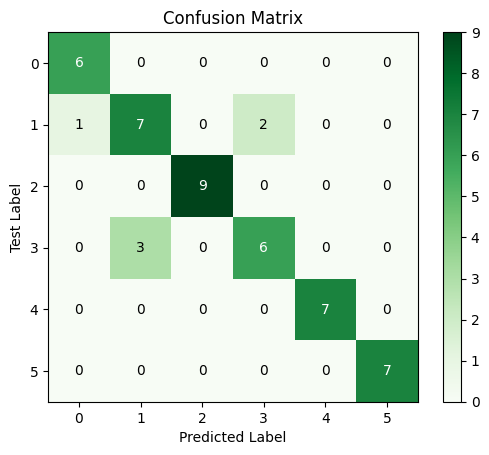

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(train_features_flat, train_labels)

knn_model = knn.fit(train_features_flat, train_labels)

accuracy_knn = knn.score(test_features_flat, test_labels)
print("Accuracy:", accuracy_knn)
print(confusion_matrix(test_labels,predicted_labels))
kcm = confusion_matrix(test_labels, predicted_labels)
classes = np.unique(test_labels)

# Plot the confusion matrix
plt.imshow(kcm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# Label the matrix with the counts
thresh = kcm.max() / 2.0
for i, j in np.ndindex(kcm.shape):
    plt.text(j, i, kcm[i, j], ha='center', va='center', color='white' if kcm[i, j] > thresh else 'black')

# Add axis labels
plt.xlabel('Predicted Label')
plt.ylabel('Test Label')

# Show the plot
plt.show()

**KNN Model Prediction**

1/1 [==============================] - 0s 18ms/step
Predicted disease: Narrow Brown Spot


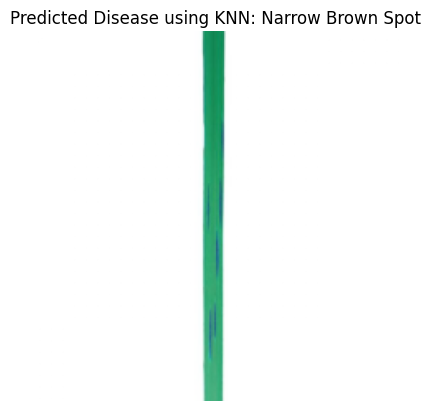

Remedies : 
Use balanced nutrients; make sure that adequate potassium is used and spray propiconazole at booting to heading stages.


In [ ]:
from skimage.transform import resize

image_path = '/content/drive/MyDrive/extracted_dataset/Narrow Brown Spot/narrow_brown-109-_jpg.rf.3370f11672d9c2224338e1bed4c204f9.jpg'
img = cv2.imread(image_path)
resized_img = resize(img, (224, 224))
test_feature = base_model.predict(np.expand_dims(resized_img, axis=0))
test_feature_flat = test_feature.reshape(1, -1)

predicted_label = knn_model.predict(test_feature_flat)

predicted_disease_name = label_encoder.inverse_transform(predicted_label)[0]

print("Predicted disease:",predicted_disease_name)
plt.imshow(resized_img)
plt.axis('off')
plt.title("Predicted Disease using KNN: " + predicted_disease_name)
plt.show()


print("Remedies : ")
if(predicted_disease_name == "Bacterial Leaf Blight"):
     print('Use disease-free seeds and rotate paddy with non-host crops.\nApply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or bactericides like streptomycin sulfate.')
if(predicted_disease_name == "Brown Spot"):
     print("Plant paddy at the recommended time and use resistant varieties.\nApply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.")
if(predicted_disease_name == "Healthy"):
     print("Its Healthy leaf .. No remedies Required")
if(predicted_disease_name == "Leaf Smut"):
     print("Treat paddy seeds with recommended fungicides like carbendazim or \nthiophanate-methyl before planting.\nApply fungicides during the early stages of the crop as a preventive \nmeasure against leaf smut.")
if(predicted_disease_name == "Narrow Brown Spot"):
    print("Use balanced nutrients; make sure that adequate potassium is used and spray propiconazole at booting to heading stages.")

**Model Training using Random Forest**

Accuracy: 0.8333333333333334
[[6 0 0 0 0 0]
 [1 7 0 2 0 0]
 [0 0 9 0 0 0]
 [0 3 0 6 0 0]
 [0 0 0 0 7 0]
 [0 0 0 0 0 7]]


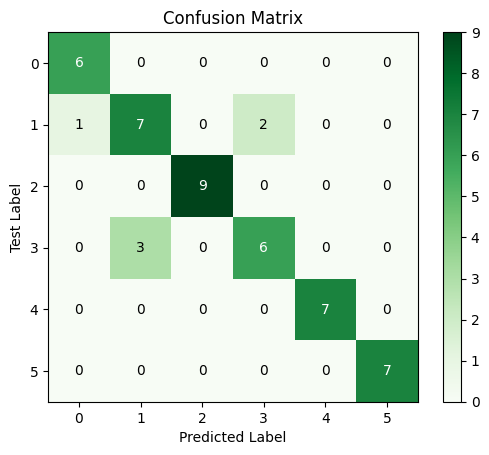

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(train_features_flat, train_labels)
rf_model = rf.fit(train_features_flat, train_labels)

accuracy_r = rf.score(test_features_flat, test_labels)
print("Accuracy:", accuracy_r)
print(confusion_matrix(test_labels,predicted_labels))

rdf = confusion_matrix(test_labels, predicted_labels)
classes = np.unique(test_labels)

# Plot the confusion matrix
plt.imshow(rdf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# Label the matrix with the counts
thresh = rdf.max() / 2.0
for i, j in np.ndindex(kcm.shape):
    plt.text(j, i, rdf[i, j], ha='center', va='center', color='white' if rdf[i, j] > thresh else 'black')

# Add axis labels
plt.xlabel('Predicted Label')
plt.ylabel('Test Label')

# Show the plot
plt.show()

**RandomForest Model Prediction**

1/1 [==============================] - 0s 18ms/step
Predicted disease: Bacterial Leaf Blight


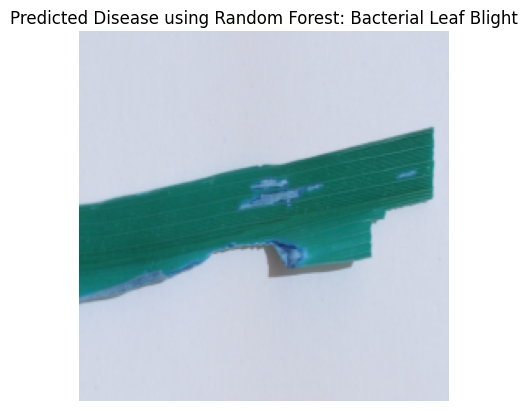

Remedies : 
Use disease-free seeds and rotate paddy with non-host crops.
Apply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or bactericides like streptomycin sulfate.


In [ ]:
from skimage.transform import resize

image_path = '/content/drive/MyDrive/extracted_dataset/Bacterial leaf blight/DSC_0365.JPG'
img = cv2.imread(image_path)
resized_img = resize(img, (224, 224))
test_feature = base_model.predict(np.expand_dims(resized_img, axis=0))
test_feature_flat = test_feature.reshape(1, -1)

predicted_label = rf_model.predict(test_feature_flat)

predicted_disease_name = label_encoder.inverse_transform(predicted_label)[0]

print("Predicted disease:",predicted_disease_name)
plt.imshow(resized_img)
plt.axis('off')
plt.title("Predicted Disease using Random Forest: " + predicted_disease_name)
plt.show()


print("Remedies : ")
if(predicted_disease_name == "Bacterial Leaf Blight"):
     print('Use disease-free seeds and rotate paddy with non-host crops.\nApply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or bactericides like streptomycin sulfate.')
if(predicted_disease_name == "Brown Spot"):
     print("Plant paddy at the recommended time and use resistant varieties.\nApply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.")
if(predicted_disease_name == "Healthy"):
     print("Its Healthy leaf .. No remedies Required")
if(predicted_disease_name == "Leaf Smut"):
     print("Treat paddy seeds with recommended fungicides like carbendazim or thiophanate-methyl before planting.\nApply fungicides during the early stages of the crop as a preventive measure against leaf smut.")
if(predicted_disease_name == "Narrow Brown Spot"):
    print("Use balanced nutrients; make sure that adequate potassium is used and spray propiconazole at booting to heading stages.")

In [ ]:
print("Accuracy (SVM):", accuracy)
print("Accuracy (Random Forest): ",accuracy_r)
print("Accuracy (KNN): ", accuracy_knn)

Accuracy (SVM): 0.875
Accuracy (Random Forest):  0.8333333333333334
Accuracy (KNN):  0.7291666666666666


In [ ]:
from tabulate import tabulate

# Example accuracy values (replace with your own)
accuracy_values = {
    'SVM': accuracy,
    'KNN': accuracy_knn,
    'Random Forest': accuracy_r
}

# Prepare the data for the table
table_data = []
for model, accuracy in accuracy_values.items():
    table_data.append([model, accuracy])

# Set the headers for the table
headers = ['Model', 'Accuracy']

# Generate the table
table = tabulate(table_data, headers, tablefmt='fancy_grid')

# Print the table
print(table)

╒═══════════════╤════════════╕
│ Model         │   Accuracy │
╞═══════════════╪════════════╡
│ SVM           │   0.875    │
├───────────────┼────────────┤
│ KNN           │   0.729167 │
├───────────────┼────────────┤
│ Random Forest │   0.833333 │
╘═══════════════╧════════════╛


**AREA INTENSITY DETECTION FOR BACTERIAL LEAF BLIGHT DISEASE IMAGE**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/DSC_0372.JPG')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([20, 50, 50])  # Adjusting these values according to  specific disease characteristics
upper_color = np.array([40, 255, 255])  # Adjusting these values according to specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)

# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#contour_image = np.zeros_like(image)
# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]
#print(total_area)
# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)

    x, y, w, h = cv2.boundingRect(contour)
    length = h
    width = w

    # Assuming you have the pixel resolution or scale factor in mm/pixel
    pixel_resolution_mm = 0.1  # Pixel resolution in mm/pixel

    # Calculate the length and width in millimeters
    length_mm = length * pixel_resolution_mm
    width_mm = width * pixel_resolution_mm

    # Update the total affected area
    affected_area += area

   # Calculate the affected area in mm^2
    affected_area_mm2 = length_mm * width_mm

# Print the length and width of the affected area
#print("Length:  {} mm".format(length_mm))
#print("Width: {} mm" .format(width_mm))

# Print the affected area
print("Total affected Area in mm^2 : {} mm^2".format(affected_area_mm2))

# Print the total affected area
print("Total affected area in pixels :", affected_area, "pixels")

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Print the affected area percentage
print("Total affected area in percentage:", affected_area_percentage, "%")

Disease_Area  = (affected_area_percentage / 100) * total_area

# Display the image with disease-affected areas highlighted
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

**AREA INTENSITY DETECTION FOR BROWN SPOT DISEASE IMAGE**

Total affected Area in mm^2 : 39.52 mm^2
Total affected area in pixels : 38421.0 pixels
Total affected area in percentage: 9.732946254863812 %


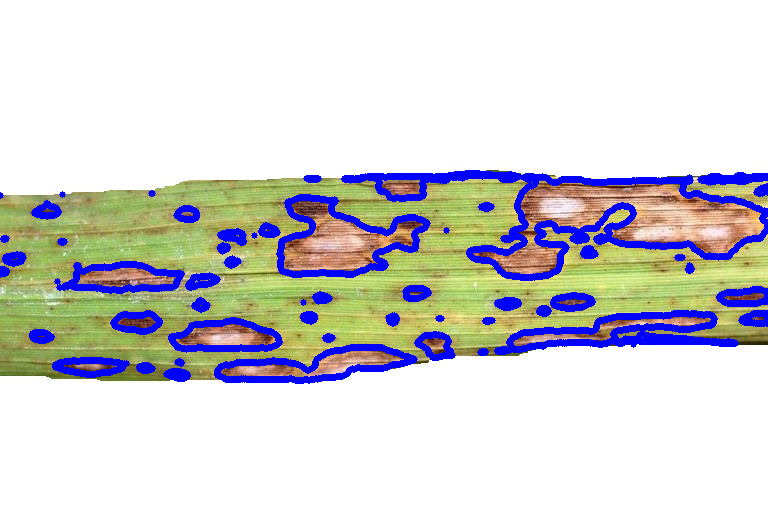

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/DSC_0113.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)



# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([0, 50, 50])  # Adjusting these values according to specific disease characteristics
upper_color = np.array([20, 255, 255])  # Adjusting these values according to  specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)




# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#contour_image = np.zeros_like(image)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]

# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    length = h
    width = w

    # Assuming you have the pixel resolution or scale factor in mm/pixel
    pixel_resolution_mm = 0.1  # Pixel resolution in mm/pixel

    # Calculate the length and width in millimeters
    length_mm = length * pixel_resolution_mm
    width_mm = width * pixel_resolution_mm

    # Update the total affected area
    affected_area += area

    # Calculate the affected area in mm^2
    affected_area_mm2 = length_mm * width_mm

# Print the affected area
print("Total affected Area in mm^2 : {} mm^2".format(affected_area_mm2))

# Print the total affected area
print("Total affected area in pixels :", affected_area, "pixels")

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Print the affected area percentage
print("Total affected area in percentage:", affected_area_percentage, "%")

# Display the image with disease-affected areas highlighted
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

**AREA INTENSITY DEETECTION FOR HEALTHY LEAF IMAGE**

Total affected area in mm^2 : 0 mm²
Total affected area: 0 pixels
Disease-affected area percentage: 0.0 %


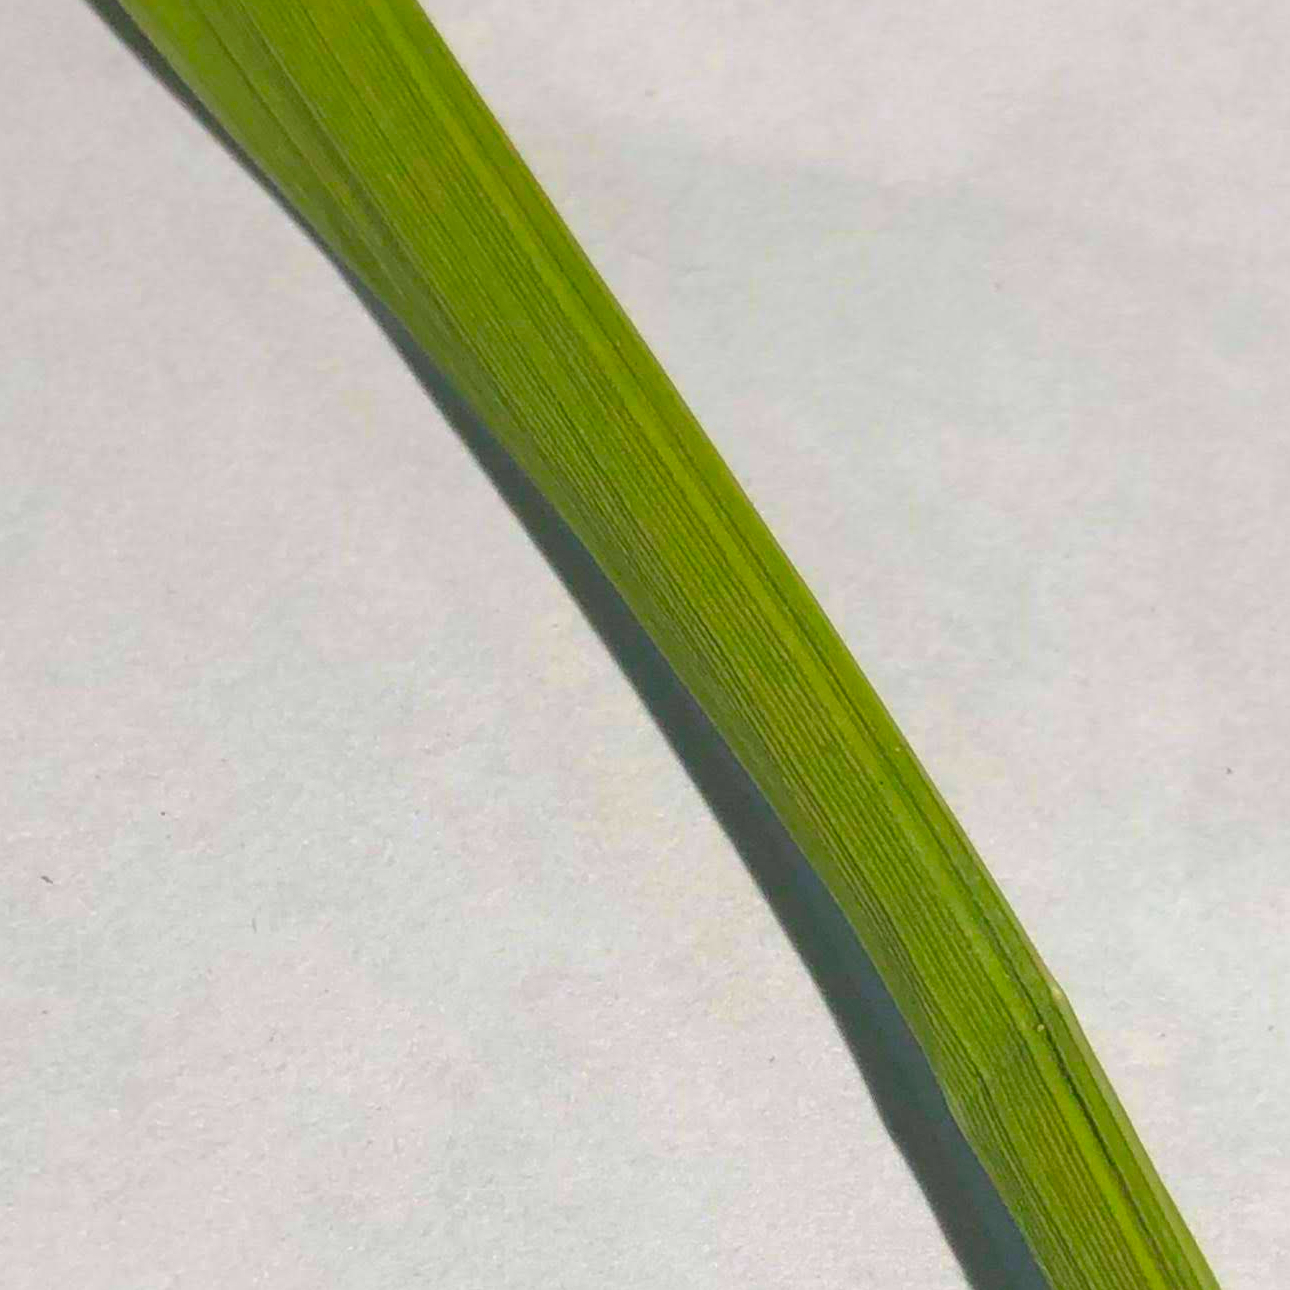

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/IMG_3233.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)



# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([0, 50, 50])  # Adjust these values according to your specific disease characteristics
upper_color = np.array([10, 255, 255])  # Adjust these values according to your specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)




# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#contour_image = np.zeros_like(image)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]

# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)


    # Update the total affected area
    affected_area += area

total_affected_area = 0
print("Total affected area in mm^2 :", total_affected_area, "mm²")


# Print the total affected area
print("Total affected area:", affected_area, "pixels")

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Print the affected area percentage
print("Disease-affected area percentage:", affected_area_percentage, "%")

# Display the image with disease-affected areas highlighted
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

**AREA INTENSITY FOR LEAF SMUT DISEASE IMAGE LEAF**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/DSC_0504.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)



# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([0, 255, 50])  # Adjust these values according to your specific disease characteristics
upper_color = np.array([180, 255, 255])  # Adjust these values according to your specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)




# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#contour_image = np.zeros_like(image)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]

# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    length = h
    width = w

    # Assuming you have the pixel resolution or scale factor in mm/pixel
    pixel_resolution_mm = 0.1  # Pixel resolution in mm/pixel

    # Calculate the length and width in millimeters
    length_mm = length * pixel_resolution_mm
    width_mm = width * pixel_resolution_mm

    # Update the total affected area
    affected_area += area

    # Calculate the affected area in mm^2
    affected_area_mm2 = length_mm * width_mm

# Print the affected area
print("Total affected Area in mm^2 : {} mm^2".format(affected_area_mm2))

# Print the total affected area
print("Total affected area in pixels:", affected_area, "pixels")

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Print the affected area percentage
print("Total affected area in percentage:", affected_area_percentage, "%")

# Display the image with disease-affected areas highlighted
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

**AREA INTENSITY FOR NARROW BROWN SPOT DISEASE IMAGE LEAF**


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/DSC_0372.JPG')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([20, 50, 50])  # Adjusting these values according to  specific disease characteristics
upper_color = np.array([40, 255, 255])  # Adjusting these values according to specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)

# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#contour_image = np.zeros_like(image)
# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]
#print(total_area)
# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)

    x, y, w, h = cv2.boundingRect(contour)
    length = h
    width = w

    # Assuming you have the pixel resolution or scale factor in mm/pixel
    pixel_resolution_mm = 0.1  # Pixel resolution in mm/pixel

    # Calculate the length and width in millimeters
    length_mm = length * pixel_resolution_mm
    width_mm = width * pixel_resolution_mm

    # Update the total affected area
    affected_area += area

   # Calculate the affected area in mm^2
    affected_area_mm2 = length_mm * width_mm

# Print the length and width of the affected area
#print("Length:  {} mm".format(length_mm))
#print("Width: {} mm" .format(width_mm))

# Print the affected area
print("Total affected Area in mm^2 : {} mm^2".format(affected_area_mm2))

# Print the total affected area
print("Total affected area in pixels :", affected_area, "pixels")

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Print the affected area percentage
print("Total affected area in percentage:", affected_area_percentage, "%")

Disease_Area  = (affected_area_percentage / 100) * total_area

# Display the image with disease-affected areas highlighted
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

**AREA INTENSITY FOR RICE BLAST DISEASE IMAGE LEAF**


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/DSC_0372.JPG')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([20, 50, 50])  # Adjusting these values according to  specific disease characteristics
upper_color = np.array([40, 255, 255])  # Adjusting these values according to specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)

# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#contour_image = np.zeros_like(image)
# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]
#print(total_area)
# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)

    x, y, w, h = cv2.boundingRect(contour)
    length = h
    width = w

    # Assuming you have the pixel resolution or scale factor in mm/pixel
    pixel_resolution_mm = 0.1  # Pixel resolution in mm/pixel

    # Calculate the length and width in millimeters
    length_mm = length * pixel_resolution_mm
    width_mm = width * pixel_resolution_mm

    # Update the total affected area
    affected_area += area

   # Calculate the affected area in mm^2
    affected_area_mm2 = length_mm * width_mm

# Print the length and width of the affected area
#print("Length:  {} mm".format(length_mm))
#print("Width: {} mm" .format(width_mm))

# Print the affected area
print("Total affected Area in mm^2 : {} mm^2".format(affected_area_mm2))

# Print the total affected area
print("Total affected area in pixels :", affected_area, "pixels")

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Print the affected area percentage
print("Total affected area in percentage:", affected_area_percentage, "%")

Disease_Area  = (affected_area_percentage / 100) * total_area

# Display the image with disease-affected areas highlighted
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.